In [1]:
import importlib
import sys,os,math,time

gostNetsFolder = os.path.dirname(os.getcwd())
sys.path.insert(0, gostNetsFolder)
from GOSTNets import GOSTnet as gn

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio

from shapely.geometry import Point

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [2]:
pth = os.path.join(gostNetsFolder, "SampleData")
boundfile = r'AOI.shp'
tif = r'SampleFlood.tif'
tif_path = os.path.join(pth, tif)
points1 = os.path.join(pth, "origins.shp")
points2 = os.path.join(pth, "destinations.shp")

### Generate shape from shapefile

In [3]:
shp = gpd.read_file(os.path.join(pth, boundfile))
bound = shp.geometry.iloc[0]

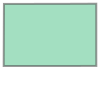

In [4]:
bound

### Get OSM Graph of Road Network

In [5]:
G = ox.graph_from_polygon(bound, network_type = 'drive')

Have a look at what an edge looks like

In [6]:
gn.example_edge(G, 1)

(6010044417, 336031716, {'osmid': 25786057, 'name': 'Kamunde Road', 'highway': 'unclassified', 'oneway': False, 'length': 171.44299999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000234EE693D30>})


In [7]:
print('number of roads in object: %d' % G.number_of_edges())
print('number of nodes in object: %d' % G.number_of_nodes())

number of roads in object: 68954
number of nodes in object: 27945


### Convert Network to Time

In [8]:
speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [9]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [10]:
gn.example_edge(G, 1)

(6010044417, 336031716, {'osmid': 25786057, 'name': 'Kamunde Road', 'highway': 'unclassified', 'oneway': False, 'length': 171.44299999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000234EE693D30>, 'time': 30.859739999999995, 'mode': 'drive'})


### Create association between points and road network nodes

Prepare the point dataframe - make a GeoDataFrame, set crs to WGS84

In [11]:
'''
pointdf = pd.read_csv(points1)
pointdf['geometry'] = list((zip(pointdf.lon, pointdf.lat)))
pointdf['geometry'] = pointdf['geometry'].apply(lambda x: Point(x))
pointgdf = gpd.GeoDataFrame(pointdf, crs = {'init':'espg:4326'}, geometry = 'geometry')
'''
pointgdf = gpd.read_file(points1)

Find the nearest node to each input point. These may not be unique (two or more firms might be mapped to same node)

In [12]:
point_df_with_nearest_node_field = gn.pandana_snap(G, pointgdf)
point_df_with_nearest_node_field

C:\Users\wb493355\OneDrive - WBG\Geospatial\GOSTnets\GOSTNets\GOSTnet.py:1650: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
C:\Users\wb493355\OneDrive - WBG\Geospatial\GOSTnets\GOSTNets\GOSTnet.py:1652: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


,id,geometry,x,y,NN
0,1,POINT (36.75688844367101 -1.393906824204006),36.756888,-1.393907,1158145615
1,2,POINT (36.81392789914727 -1.326785558480865),36.813928,-1.326786,1849993171
2,3,POINT (36.88047393053623 -1.335101568222466),36.880474,-1.335102,5641594791
3,4,POINT (36.91374694623072 -1.24956415610855),36.913747,-1.249564,5031056577
4,5,POINT (36.78837897638186 -1.232931552114229),36.788379,-1.232932,272715829
5,7,POINT (36.81565775827907 -1.087170539080487),36.815658,-1.087171,2105894603


In [13]:
list_of_nearest_nodes = list(point_df_with_nearest_node_field.NN)
unique_list_of_nearest_nodes = list(set(list_of_nearest_nodes))

### Map flooding onto nodes

In [14]:
importlib.reload(gn)
G = gn.sample_raster(G, tif_path, property_name = 'flood_depth')

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [15]:
gn.example_node(G, 1)

(6010044417, {'y': -1.2527366, 'x': 36.8861095, 'osmid': 6010044417, 'flood_depth': 0.0})


Make a geodataframe of the nodes, check to see info has bonded on correctly

In [16]:
G_node_gdf = gn.node_gdf_from_graph(G)
print('total number of nodes: %d' % len(G_node_gdf))

total number of nodes: 27945


In [17]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.flood_depth > 0]))

number of nodes where flood depth positive: 182


In [18]:
print('number of nodes where flood depth zero: %d' % len(G_node_gdf.loc[G_node_gdf.flood_depth == 0]))

number of nodes where flood depth zero: 26292


In [19]:
# clearly, some nodes don't intersect the raster. solve this by setting flood_depth = 0 where this is the case
i = 0
for u, data in G.nodes(data = True):
    if 'flood_depth' not in data.keys():
        data['flood_depth'] = 0
        i+=1
print(i)

1471


### Calculate baseline OD-matrix with no disruption to nodes

In [20]:
# we need to pick some nodes which are near the flood to test the disruption between them - pre and post flood
proximate_nodes = []
for u, data in G.nodes(data = True):
    if data['flood_depth'] > 0.3 and data['flood_depth'] < 0.49:
        proximate_nodes.append(u)
print('number of near-flooded nodes for illustration purposes: %s' % len(proximate_nodes))

number of near-flooded nodes for illustration purposes: 34


In [21]:
test = 1
if test == 1:
    # we take the first 10 of these for our origins and the last 15 for our destinations
    origins = proximate_nodes[:10]
    destinations = proximate_nodes[-10:]
else:
    origins = unique_list_of_nearest_nodes
    destinations = unique_list_of_nearest_nodes

fail_value = 999999999999999

baseline_OD = gn.calculate_OD(G, origins, destinations, fail_value)

Throw this into a dataframe and send to .csv for future reference

In [22]:
OD_df = pd.DataFrame(baseline_OD)
OD_df.to_csv(os.path.join(pth, 'baseline_OD.csv'))

### Knock out part of the network due to a flood

methodological note: instead of actually removing a link, what this does is set the time taken to cross the link to an enormously high value (the fail value). It's a surprise tool that will help us later when summarising the OD

In [53]:
my_flood_depth = 0.45

In [54]:
importlib.reload(gn)
G_flood = G.copy()
G_flood = gn.disrupt_network(G_flood, 'flood_depth', my_flood_depth, fail_value)

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
nodes disrupted: 31
edges disrupted: 117


### Return new OD matrix

In [55]:
i = 0
for u, v, data in G_flood.edges(data = True):
    if data['time'] >= fail_value:
        i+=1
print(i)

117


In [56]:
flooded_OD = gn.calculate_OD(G_flood, origins, destinations, fail_value)
flood_OD_df = pd.DataFrame(flooded_OD)

In [57]:
flood_OD_df.to_csv(os.path.join(pth, 'flooded_OD.csv'))

### Count all of the disrupted trips

In [58]:
masked_OD = np.ma.masked_greater(flooded_OD, value = (fail_value - 1))

impossible_trips = masked_OD.mask.sum()
print(impossible_trips)

19


In [59]:
OD_df

,0,1,2,3,4,5,6,7,8,9
0,524.469240,514.858860,478.334670,504.746280,1896.643601,2991.185846,3406.421597,1797.607272,1622.403746,1278.888493
1,2785.260507,2775.650127,2765.241057,2910.481797,4188.017593,5383.383293,5434.778907,3084.958179,4014.601193,3671.085940
2,1499.468836,1489.858456,1001.784222,1147.024962,2358.592493,3619.926458,4035.162209,1277.749350,2251.144358,1907.629105
3,1216.304212,1206.693832,1890.898942,1814.686432,3206.583753,3646.328336,3519.732200,3009.129244,2277.546236,2147.865940
4,1378.850662,1369.240282,2053.445392,1977.232882,3369.130203,3808.874786,3682.278650,2744.631809,2440.092686,2310.412390
5,2240.416140,2230.805760,1480.912707,1584.405357,1337.671380,1773.227199,3532.995542,2186.561250,1342.904222,1822.557062
6,2270.732820,2261.122440,1511.229387,1614.722037,1367.988060,1803.543879,3563.312222,2216.877930,1373.220902,1852.873742
7,1491.625696,1482.015316,993.941082,1139.181822,2350.749353,3612.083318,4027.319069,1285.592490,2243.301218,1899.785965
8,724.474290,714.863910,565.575930,710.816670,1988.352466,3183.718166,3598.953917,1624.470432,1814.936066,1471.420813
9,3408.603523,3398.993143,2902.239443,2760.692593,2104.677476,75.729960,4028.784133,3327.147270,1752.978690,2668.236313


In [60]:
flood_OD_df

,0,1,2,3,4,5,6,7,8,9
0,5.244692e+02,5.148589e+02,4.783347e+02,5.047463e+02,1.000000e+15,2.991186e+03,3.406422e+03,1.797607e+03,1.622404e+03,1.278888e+03
1,2.785261e+03,2.775650e+03,2.765241e+03,2.910482e+03,1.000000e+15,5.383383e+03,5.434779e+03,3.084958e+03,4.014601e+03,3.671086e+03
2,1.499469e+03,1.489858e+03,1.001784e+03,1.147025e+03,1.000000e+15,3.619926e+03,4.035162e+03,1.277749e+03,2.251144e+03,1.907629e+03
3,1.216304e+03,1.206694e+03,1.890899e+03,1.814686e+03,1.000000e+15,3.646328e+03,3.519732e+03,3.009129e+03,2.277546e+03,2.147866e+03
4,1.378851e+03,1.369240e+03,2.053445e+03,1.977233e+03,1.000000e+15,3.808875e+03,3.682279e+03,2.744632e+03,2.440093e+03,2.310412e+03
5,2.240416e+03,2.230806e+03,1.480913e+03,1.584405e+03,1.000000e+15,1.773227e+03,3.532996e+03,2.186561e+03,1.342904e+03,1.822557e+03
6,2.270733e+03,2.261122e+03,1.511229e+03,1.614722e+03,1.000000e+15,1.803544e+03,3.563312e+03,2.216878e+03,1.373221e+03,1.852874e+03
7,1.491626e+03,1.482015e+03,9.939411e+02,1.139182e+03,1.000000e+15,3.612083e+03,4.027319e+03,1.285592e+03,2.243301e+03,1.899786e+03
8,7.244743e+02,7.148639e+02,5.655759e+02,7.108167e+02,1.000000e+15,3.183718e+03,3.598954e+03,1.624470e+03,1.814936e+03,1.471421e+03
9,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,2.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15


In [61]:
OD_df == flood_OD_df

,0,1,2,3,4,5,6,7,8,9
0,True,True,True,True,False,True,True,True,True,True
1,True,True,True,True,False,True,True,True,True,True
2,True,True,True,True,False,True,True,True,True,True
3,True,True,True,True,False,True,True,True,True,True
4,True,True,True,True,False,True,True,True,True,True
5,True,True,True,True,False,True,True,True,True,True
6,True,True,True,True,False,True,True,True,True,True
7,True,True,True,True,False,True,True,True,True,True
8,True,True,True,True,False,True,True,True,True,True
9,False,False,False,False,False,False,False,False,False,False


In [62]:
flood_gdf_edge = gn.edge_gdf_from_graph(G_flood)
flood_gdf_edge.to_csv(os.path.join(pth, 'flood_edge.csv'))
flood_gdf_node = gn.node_gdf_from_graph(G_flood)
flood_gdf_node.to_csv(os.path.join(pth, 'flood_node.csv'))